In [6]:
import numpy as np
import pickle
import math
from scipy.stats import sem
import matplotlib.pyplot as plt
import pandas as pd
import time
import pprint
import seaborn as sns
import statsmodels.formula.api as smf
import CMR_IA as cmr
import scipy as sp
sns.set_context('paper')
pd.set_option('display.max_columns', None)

In [7]:
with open("simu5_data/simu5_design.pkl", 'rb') as inp:
    df_study = pickle.load(inp)
    df_test = pickle.load(inp)
# df_study = df_study.loc[df_study.session < 500]
# df_test = df_test.loc[df_test.session < 500]

In [8]:
df_study

,study_itemno1,study_itemno2,study_item1,study_item2,list,session
0,1071,857,PIMPLE,MAILBOX,0,0
1,309,1029,CIGARETTE,PAW,0,0
2,624,700,GARLIC,HEEL,0,0
3,195,1389,BULLETIN,STRANGER,0,0
4,580,392,FLIPPER,COUSIN,0,0
...,...,...,...,...,...,...
46795,1076,1273,PISTON,SHACK,77,99
46796,88,670,BARLEY,GUITAR,77,99
46797,470,1259,DIPLOMA,SEA,77,99
46798,1397,1530,STY,TWISTER,77,99


In [9]:
df_test

,test_itemno,test_item,correct_ans,lag,list,session
0,580,FLIPPER,392,1,0,0
1,744,IRON,245,3,1,0
2,316,CLAMP,958,5,2,0
3,109,BEAVER,1326,2,3,0
4,768,KANGAROO,1632,0,4,0
...,...,...,...,...,...,...
7795,61,AUTHOR,1150,4,73,99
7796,185,BUCKLE,400,0,74,99
7797,1462,THUMB,452,2,75,99
7798,944,NERVE,1122,0,76,99


### Run CMR-IA

In [10]:
s_mat = np.load('../../Data/wordpools/ltp_FR_similarity_matrix.npy')

In [11]:
params = cmr.make_default_params()
params.update(
    beta_enc = 0.5,
    beta_cue = 0.45,
    beta_distract = 0.1,
    gamma_fc = 0.7,
    gamma_cf = 0.5,
    s_fc = 0.1,
    s_cf = 0.1,
    c_thresh = 0.01,
    kappa = 0.08,
    lamb = 0.05,
    eta = 0.02,
    phi_s = 1.2,  # control the overall f_dif correct
    phi_d = 1.1,  # control the curve of last three, higher then upper, mediated by phi_s 
    nitems_in_accumulator = 12,
    d_ass = 0.8
)
params

{'beta_enc': 0.5,
 'beta_rec': 0.5,
 'beta_cue': 0.45,
 'beta_rec_post': 0.5,
 'beta_distract': 0.1,
 'phi_s': 1.2,
 'phi_d': 1.1,
 's_cf': 0.1,
 's_fc': 0.1,
 'kappa': 0.08,
 'eta': 0.02,
 'omega': 5,
 'alpha': 1,
 'c_thresh': 0.01,
 'c_thresh_itm': 0.5,
 'c_thresh_ass': 0.5,
 'd_ass': 0.8,
 'lamb': 0.05,
 'rec_time_limit': 60000.0,
 'dt': 10,
 'nitems_in_accumulator': 12,
 'max_recalls': 50,
 'learn_while_retrieving': False,
 'a': 2800,
 'b': 20,
 'm': 0,
 'n': 1,
 'c1': 0,
 'thresh_sigma': 0,
 'No_recall': None,
 'var_enc': 1,
 'bad_enc_ratio': 1,
 'gamma_fc': 0.7,
 'gamma_cf': 0.5}

In [12]:
df_simu, f_in, f_dif = cmr.run_norm_cr_multi_sess(params,df_study, df_test ,s_mat)
df_simu

CMR2 Time: 584.2876806259155


,list,session,test_itemno,s_resp,s_rt,csim
0,0,0,580,700.0,1210.0,0.616469
1,1,0,744,115.0,1370.0,0.640307
2,2,0,316,1533.0,1770.0,0.609022
3,3,0,109,1084.0,1620.0,0.605449
4,4,0,768,1204.0,1560.0,0.552676
...,...,...,...,...,...,...
7795,73,99,61,1297.0,760.0,0.710311
7796,74,99,185,1038.0,1000.0,0.522393
7797,75,99,1462,1228.0,1390.0,0.582658
7798,76,99,944,402.0,1750.0,0.527436


In [13]:
df_simu = df_simu.merge(df_test,on=['session','test_itemno'])
df_simu['correct'] = df_simu.s_resp == df_simu.correct_ans
df_simu

,list_x,session,test_itemno,s_resp,s_rt,csim,test_item,correct_ans,lag,list_y,correct
0,0,0,580,700.0,1210.0,0.616469,FLIPPER,392,1,0,False
1,1,0,744,115.0,1370.0,0.640307,IRON,245,3,1,False
2,2,0,316,1533.0,1770.0,0.609022,CLAMP,958,5,2,False
3,3,0,109,1084.0,1620.0,0.605449,BEAVER,1326,2,3,False
4,4,0,768,1204.0,1560.0,0.552676,KANGAROO,1632,0,4,False
...,...,...,...,...,...,...,...,...,...,...,...
7795,73,99,61,1297.0,760.0,0.710311,AUTHOR,1150,4,73,False
7796,74,99,185,1038.0,1000.0,0.522393,BUCKLE,400,0,74,False
7797,75,99,1462,1228.0,1390.0,0.582658,THUMB,452,2,75,False
7798,76,99,944,402.0,1750.0,0.527436,NERVE,1122,0,76,False


In [14]:
# f_in

In [15]:
sessions = df_simu.session.to_numpy()
for sess in sessions:
    df_tmp = df_study.loc[df_study.session == sess]
    tmp1 = df_tmp.study_itemno1.to_numpy()
    tmp2 = df_tmp.study_itemno2.to_numpy()
    tmp = np.concatenate((tmp1, tmp2))
    tmp = np.sort(tmp)
    testid = np.searchsorted(tmp, df_simu.test_itemno[sess].item())
    corrid = np.searchsorted(tmp, df_simu.correct_ans[sess].item())
    df_simu.loc[df_simu.session == sess, 'corr_fin']= f_dif[sess][0][corrid]
    # df_simu.loc[df_simu.session == sess, 'omean_fin'] = np.mean(np.delete(f_in[sess][0], [testid,corrid]))
    df_simu.loc[df_simu.session == sess, 'omax_fin'] = np.delete(f_dif[sess][0], corrid).max()
df_simu

,list_x,session,test_itemno,s_resp,s_rt,csim,test_item,correct_ans,lag,list_y,correct,corr_fin,omax_fin
0,0,0,580,700.0,1210.0,0.616469,FLIPPER,392,1,0,False,-0.179978,-0.195857
1,1,0,744,115.0,1370.0,0.640307,IRON,245,3,1,False,-0.179978,-0.195857
2,2,0,316,1533.0,1770.0,0.609022,CLAMP,958,5,2,False,-0.179978,-0.195857
3,3,0,109,1084.0,1620.0,0.605449,BEAVER,1326,2,3,False,-0.179978,-0.195857
4,4,0,768,1204.0,1560.0,0.552676,KANGAROO,1632,0,4,False,-0.179978,-0.195857
...,...,...,...,...,...,...,...,...,...,...,...,...,...
7795,73,99,61,1297.0,760.0,0.710311,AUTHOR,1150,4,73,False,-0.865888,-0.235114
7796,74,99,185,1038.0,1000.0,0.522393,BUCKLE,400,0,74,False,-0.865888,-0.235114
7797,75,99,1462,1228.0,1390.0,0.582658,THUMB,452,2,75,False,-0.865888,-0.235114
7798,76,99,944,402.0,1750.0,0.527436,NERVE,1122,0,76,False,-0.865888,-0.235114


In [16]:
df_fin = df_simu.groupby('lag')[['corr_fin','omax_fin']].mean().reset_index()
df_fin['dif'] = df_fin['corr_fin'] - df_fin['omax_fin']
df_fin

,lag,corr_fin,omax_fin,dif
0,0,-0.867260,-0.214793,-0.652467
1,1,-0.867692,-0.214114,-0.653578
2,2,-0.867906,-0.214325,-0.653581
3,3,-0.871168,-0.214938,-0.656230
4,4,-0.871767,-0.216112,-0.655655
5,5,-0.868534,-0.212755,-0.655779


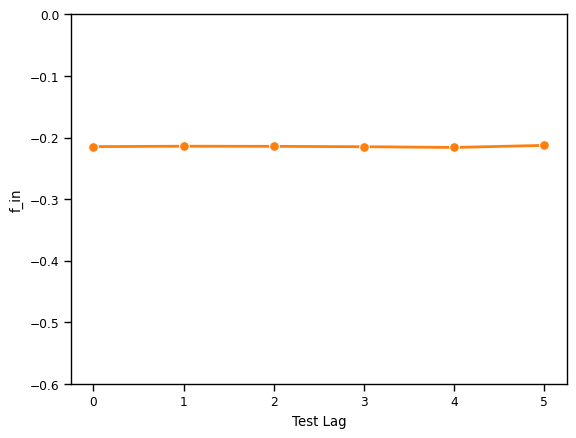

In [17]:
sns.lineplot(data=df_fin, x='lag', y='corr_fin', linewidth=2, marker='o', markersize = 7)
# sns.lineplot(data=df_fin, x='lag', y='omean_fin', linewidth=2, marker='o', markersize = 7)
sns.lineplot(data=df_fin, x='lag', y='omax_fin', linewidth=2, marker='o', markersize = 7)
plt.ylim([-0.6,0])
plt.xlabel('Test Lag')
plt.ylabel('f_in')
# plt.savefig('fig/simu3_hr.pdf')
plt.show()

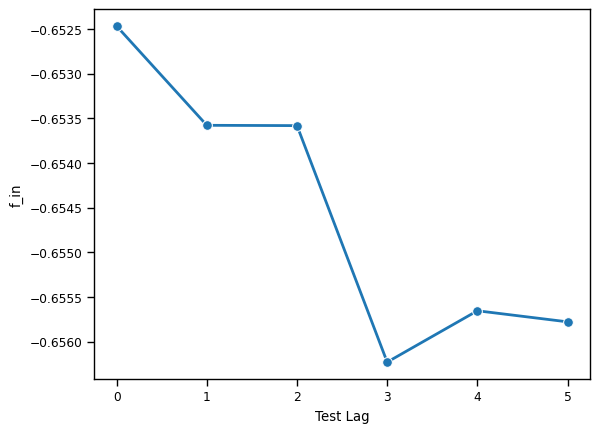

In [18]:
sns.lineplot(data=df_fin, x='lag', y='dif', linewidth=2, marker='o', markersize = 7)
# plt.ylim([0,1])
plt.xlabel('Test Lag')
plt.ylabel('f_in')
# plt.savefig('fig/simu3_hr.pdf')
plt.show()

### PLOT

In [19]:
df_laggp = df_simu.groupby(['lag']).correct.mean().to_frame(name='corr_rate').reset_index()
df_laggp

,lag,corr_rate
0,0,0.482389
1,1,0.236700
2,2,0.118708
3,3,0.080694
4,4,0.108580
5,5,0.896975


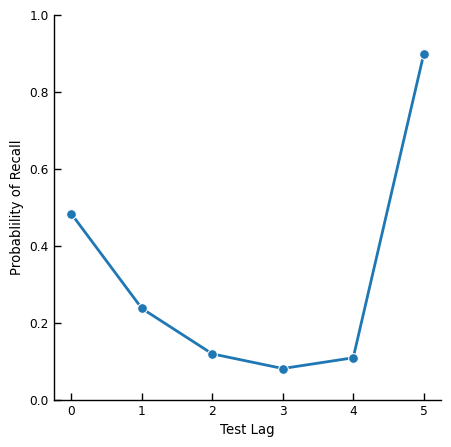

In [20]:
fig,ax = plt.subplots(figsize=(5,5))
ax.spines[['right', 'top']].set_visible(False)
ax.tick_params(axis="y",direction="in")
ax.tick_params(axis="x",direction="in")
sns.lineplot(data=df_laggp, x='lag', y='corr_rate', linewidth=2, marker='o', markersize = 7)
plt.ylim([0,1])
plt.xlabel('Test Lag')
plt.ylabel('Probablility of Recall')
# plt.savefig('simu5_fig/simu5_recall.pdf')
plt.show()